# Goal
This post aims to break down the module [`dtreeviz`](https://github.com/parrt/dtreeviz) module step by step to fully understand what is implemented. After fully understanding this, I would like to contribute to this module and submit a pull request. 

I really like this module and would like to see this works for other tree-based modules like XGBoost or Lightgbm. I found [the exact same issue (issues 15)](https://github.com/parrt/dtreeviz/issues/15) in github so I hope I could contribute to this issue.

This post is the 4th part: breaking down `DTreeViz` class and `rtreeviz_univar` method. 

**Reference**
* [Github dtreeviz](https://github.com/parrt/dtreeviz)
* [Scikit-Learn - Tree](https://scikit-learn.org/stable/modules/tree.html)
* [Step by Step Data Science - Split-Up: dtreeviz (Part 1)](https://h1ros.github.io/posts/split-up-dtreevis-part-1/)
* [Step by Step Data Science - Split-Up: dtreeviz (Part 2)](https://h1ros.github.io/posts/split-up-dtreevis-part-2/)
* [Step by Step Data Science - Split-Up: dtreeviz (Part 3)](https://h1ros.github.io/posts/split-up-dtreevis-part-3/)
 

# `DTreeViz` class

- L23: the beginning of `DTreeViz` class
- L24-25: `__init__` method taking `dot` object as an input 
- L26-78: deal with save, view the visualization as svg file 

## rtreeviz_univar
- L81: the beginning of `rtreeviz_univar` method
- L94-102: initial setting for the range of X, y data and converting them into numpy array.
- L104-105: create a scikit-learn decision tree
- L121-122: plot the original X and y data points
- L125-126: plot the vertical line for decision boundary (gray line)
- L128-134: plot the horizontal line for mean line (red line by default)
- L136: Change the appearance of ticks
- L138-140: setting title
- L142-143: setting x and y label based on `feature_name` and `target_name`

In [4]:
from pathlib import Path
from graphviz.backend import run, view
import matplotlib.pyplot as plt
from dtreeviz.shadow import *
from numbers import Number
import matplotlib.patches as patches
import tempfile
import os
from sys import platform as PLATFORM
from colour import Color, rgb2hex
from typing import Mapping, List
from dtreeviz.utils import inline_svg_images, myround
from dtreeviz.shadow import ShadowDecTree, ShadowDecTreeNode
from dtreeviz.colors import adjust_colors
from sklearn import tree
import graphviz

# How many bins should we have based upon number of classes
NUM_BINS = [0, 0, 10, 9, 8, 6, 6, 6, 5, 5, 5]
          # 0, 1, 2,  3, 4, 5, 6, 7, 8, 9, 10

def rtreeviz_univar(ax,
                    x_train: (pd.Series, np.ndarray),  # 1 vector of X data
                    y_train: (pd.Series, np.ndarray),
                    max_depth = 10,
                    feature_name: str = None,
                    target_name: str = None,
                    min_samples_leaf = 1,
                    fontsize: int = 14,
                    show={'title','splits'},
                    split_linewidth=.5,
                    mean_linewidth = 2,
                    markersize=None,
                    colors=None):
    if isinstance(x_train, pd.Series):
        x_train = x_train.values
    if isinstance(y_train, pd.Series):
        y_train = y_train.values

    colors = adjust_colors(colors)

    y_range = (min(y_train), max(y_train))  # same y axis for all
    overall_feature_range = (np.min(x_train), np.max(x_train))

    t = tree.DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    t.fit(x_train.reshape(-1,1), y_train)

    shadow_tree = ShadowDecTree(t, x_train.reshape(-1,1), y_train, feature_names=[feature_name])
    splits = []
    for node in shadow_tree.internal:
        splits.append(node.split())
    splits = sorted(splits)
    bins = [overall_feature_range[0]] + splits + [overall_feature_range[1]]

    means = []
    for i in range(len(bins) - 1):
        left = bins[i]
        right = bins[i + 1]
        inrange = y_train[(x_train >= left) & (x_train <= right)]
        means.append(np.mean(inrange))

    ax.scatter(x_train, y_train, marker='o', alpha=.4, c=colors['scatter_marker'], s=markersize,
               edgecolor=colors['scatter_edge'], lw=.3)

    if 'splits' in show:
        for split in splits:
            ax.plot([split, split], [*y_range], '--', color=colors['split_line'], linewidth=split_linewidth)

        prevX = overall_feature_range[0]
        for i, m in enumerate(means):
            split = overall_feature_range[1]
            if i < len(splits):
                split = splits[i]
            ax.plot([prevX, split], [m, m], '-', color=colors['mean_line'], linewidth=mean_linewidth)
            prevX = split

    ax.tick_params(axis='both', which='major', width=.3, labelcolor=colors['tick_label'], labelsize=fontsize)

    if 'title' in show:
        title = f"Regression tree depth {max_depth}, samples per leaf {min_samples_leaf},\nTraining $R^2$={t.score(x_train.reshape(-1,1),y_train):.3f}"
        plt.title(title, fontsize=fontsize, color=colors['title'])

    plt.xlabel(feature_name, fontsize=fontsize, color=colors['axis_label'])
    plt.ylabel(target_name, fontsize=fontsize, color=colors['axis_label'])

## Create a toy sample 

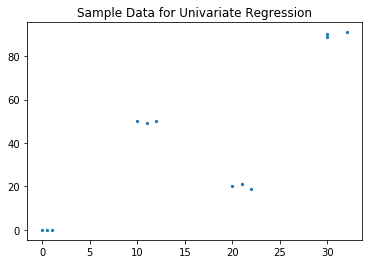

In [42]:
import numpy as np
import graphviz 
from sklearn import tree

X = np.array([0, 1, 0.5, 10, 11, 12, 20, 21, 22, 30, 30, 32]).reshape(-1, 1)
Y = np.array([0., 0, 0, 50, 49, 50, 20, 21, 19, 90, 89, 91]).reshape(-1, 1)
clf = tree.DecisionTreeRegressor(max_depth=3)
clf = clf.fit(X, Y)

plt.scatter(x=X, y=Y, s=5);
plt.title('Sample Data for Univariate Regression');

## Visualize a tree using `rtreeviz_univar`

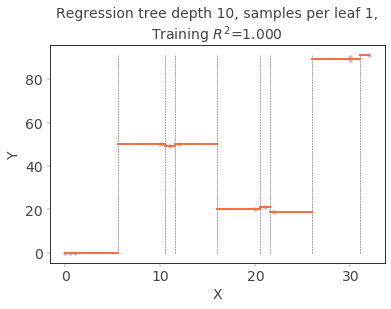

In [51]:
fig, ax = plt.subplots(1)
rtreeviz_univar(ax, pd.Series(X.ravel()), pd.Series(Y.ravel()), 
                feature_name='X', 
                target_name='Y',
                markersize=15)